In [2]:
%%capture
!pip install --upgrade pandas
!pip install -U geopandas 
!pip install statsmodels
!pip install seaborn
!pip install -U rtree mapclassify fiona pyproj
!sudo apt install libspatialindex-dev
!pip install openpyxl
# Cargar archivo de datos geográficos de los municipios de Colombia.

# Primero necesitamos instalar la utilidad 'gdown' debido al tamaño del archivo:
!pip install --upgrade gdown
!pip install unzip

# **Proyecto Aplicado Modulo 1: Análisis y visualización de datos con *Python***
---
**Autor**: Luis Felipe De La Ossa Mayorga

En este notebook se presentan los resultados correspondientes al análisis de datos del dataset público, propiedad de la plataforma **StockX**, especializada en reventa de artículos (principalmente Sneakers) y usado para el 'StockX Data Contest' del año 2019.



## Importación de Librerías
------
Para este proyecto se trabajarán principalmente 5 librerías, estas son:


*   Numpy
*   Scipy
*   Pandas
*   Seaborn
*   Plotly
*   Geopandas

Las tres últimas construidas sobre matplotly y sus funciones características.





In [3]:
# Importación de librerías

import numpy as np
import pandas as pd
import scipy
import seaborn as sns
import geopandas as gpd
import matplotlib.pyplot as plt 

#Funciones Especiales
from scipy import stats
import statsmodels.api as sm       
import shapely                  # Librería de manipulación de objetos geométricos.
from shapely.geometry import*
import plotly.graph_objs as go 
import plotly.express as px
from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib inline
plt.rcParams['figure.dpi'] = 110 

## **Descripción del dataset**

-------

El dataset trabajado en este proyecto llamado originalmente **"StockX-Data-Contest-2019-3"** es un conjunto de datos publicado en el año 2019 por la plataforma StockX con el objetivo de llevar a cabo su "Data Contest", incentivando la creatividad de los usuarios de la plataforma para hacer analisis de dattos y modelos de Machine Learning en base a estos datos.
El dataset cuenta con un total de 99956 registros de ventas  en USA de la platforma de los cuales 27794 corresponden a modelos de Sneakers de Off-White(En colaboración con Nike) y 72162 corresponden a modelos Yeezy (Propiedad de Adidas en ese momento). 


## **Problema** 
------

El problema a resolver abarca diferentes subproblemas que van desde el análisis exploratorio de los datos (hallando los márgenes de ganancias de las ventas e identificando outliers), visualización y análisis por ubicación geográfica y modelos predictivos del valor de los diferentes modelos de Sneaker (Haciendo una comparativa con el precio actual de los modelos 4 años después de publicado el dataset).

## **Objetivos** 
------
**Objetivo General**:

Realizar modelado analítico y estadístico de los datos con el objetivo de entender con mayor profundidad las ventas realizadas por la plataforma **StockX**, presentadas en el dataset correspondiente.

**Objetivos Específicos**:

*   Comprender con ayuda de diferentes tipos de gráficos y  de manera objetiva los datos presentados por StockX, incluyendo el número de ventas, el precio de Reventa y el precio de Retail, buscando dependencias con el tiempo y con la ubicación geográfica de los compradores.

*   Realizar análisis predictivos del valor en el mercado de algunos modelos de Sneaker y comprar esta predicción con su valor actual.




## Carga De Datos
------

In [4]:
%%capture

#Descarga de datos desde Drive
!gdown https://drive.google.com/uc?id=1TCDTSvq0uGftTK-mMV30_TYIBnE164c5 #Data Stcok X
!gdown https://drive.google.com/uc?id=1wNo7x9A79pai4NxNkj21Hvv2shX65E1Y ##data estados USA

!unzip s_08mr23.zip #Extraer el archivo para geopandas del zip de los estados descargado en la line anterior

In [5]:
Stock_original = pd.read_excel('Proyecto.xlsx',sheet_name='Raw Data')
States_fig = gpd.read_file(r"s_08mr23.shp")

## **Descripción de los Datos** 
------

In [7]:
Stock_original.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99956 entries, 0 to 99955
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Order Date    99956 non-null  datetime64[ns]
 1   Brand         99956 non-null  object        
 2   Sneaker Name  99956 non-null  object        
 3   Sale Price    99956 non-null  float64       
 4   Retail Price  99956 non-null  int64         
 5   Release Date  99956 non-null  datetime64[ns]
 6   Shoe Size     99956 non-null  float64       
 7   Buyer Region  99956 non-null  object        
dtypes: datetime64[ns](2), float64(2), int64(1), object(3)
memory usage: 6.1+ MB


In [8]:
States_fig.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 59 entries, 0 to 58
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   STATE     59 non-null     object  
 1   NAME      59 non-null     object  
 2   FIPS      59 non-null     object  
 3   LON       59 non-null     float64 
 4   LAT       59 non-null     float64 
 5   geometry  59 non-null     geometry
dtypes: float64(2), geometry(1), object(3)
memory usage: 2.9+ KB


## **Análisis Exploratorio y Estadístico de los Datos**

--------

A continuación se mostrarán los resultados hallados por medio de los diferentes análisis de datos aprendidos en el primer módulo del diplomado **MLDS**.

### **Análisis de los Registros que Representaron Perdidas para los Vendedores**

Para esta sección se realizará un análisis de las ventas que significaron una perdida para el vendedor teniendo en cuenta el precio de Retail de las Marcas (Nike y Adidas) y el precio de reventa en la plataforma StockX con sus respectivas comisiones.

**StockX** en cada venta cobra una taza de transacción (9%-10% del valor de la venta), una taza de procesamiento del pago (3% de la venta) y dependiendo de la ubicación del vendedor, el pago por el envío de los Sneaker al centro de autenticación más cercano de **StockX**.

En este caso solo se tendrán en cuenta las dos primeras tazas que se descuentan del valor de la venta, ya que la taza de envío varía bastante dependiendo de la ubicación del vendedor.

In [9]:
###Perdidas

#Nueva Columna True Sale Correspondiente a la verdadera cantidad recibida por el vendedor luego de los descuentos
Stock_original['True Sale']=(Stock_original['Sale Price'])-(Stock_original['Sale Price']*0.1)-(Stock_original['Sale Price']*0.03)

#Nueva Columna correspondiente a las ganancias recibidad por el vendedor luego de la venta y teniendo
#En cuenta el dinero que posiblemente pagó en Retail.

Stock_original['Profit']=Stock_original['True Sale']-Stock_original['Retail Price']

#Nuegvo dataset que sólo esta conformado por las ventas que presentaron perdidas para el vendedor
Sneakers_perdidas=Stock_original[Stock_original['Profit']<=0].reset_index()

Sneakers_perdidas['Sneaker Name'].value_counts()

Adidas-Yeezy-Boost-350-V2-Cream-White             4879
adidas-Yeezy-Boost-350-V2-Butter                  2522
Adidas-Yeezy-Boost-350-V2-Sesame                  1501
Adidas-Yeezy-Boost-350-V2-Semi-Frozen-Yellow       989
adidas-Yeezy-Boost-350-V2-Static                    84
Nike-Zoom-Fly-Mercurial-Off-White-Total-Orange      28
Adidas-Yeezy-Boost-350-V2-Beluga-2pt0                1
Name: Sneaker Name, dtype: int64

Como se puede apreciar por los datos anteriores, la marca que presenta los Sneaker menos rentables para reventa fue Adidas.
Esto es comprensible, ya que a pesar de la popularidad de los Yeezy (Adidas en colaboración con Kanye West), muchos de sus productos no causan el revuelo necesario para subir su precio en reventa debido a su similitud con productos actuales o anteriores. 

En este Caso, Nike solo presenta un modelo entre sus Sneakers menos rentables para la reventa, esto se puede deber a que en los últimos 10 años, Nike ha causado más revuelo con sus lanzamientos en USA, haciendo que los compradores paguen más en reventa por sus modelos [1].

A continuación se presenta un histograma de los resultados anteriores.

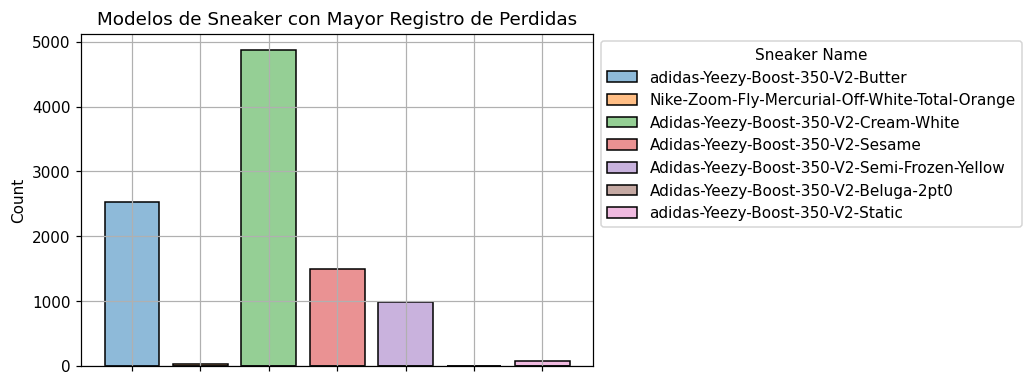

In [10]:
his=sns.histplot(data=Sneakers_perdidas, x="Sneaker Name",hue='Sneaker Name', shrink=.8 );
sns.move_legend(his, "upper left", bbox_to_anchor=(1, 1))
his.set_title('Modelos de Sneaker con Mayor Registro de Perdidas')
his.set_xlabel(None)
his.grid()
his.tick_params(labelbottom=False)

### **Análisis de la Dependencía de la Talla del Modelo en el Precio de Reventa**

Inicialmente ser observarán las varianzas de los datos para determinar si hay o no hay homoscedasticidad y así determinar que modelo analítico se usará.


In [20]:
Stock_original.groupby('Shoe Size').var();

<ipython-input-20-7d90555db98a>:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.var is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  Stock_original.groupby('Shoe Size').var();


Como se puede notar por la operación anterior, las varianzas del precio de venta según la talla del modelo **No** tiene un comportamiento constante y sus valores son muy distintos.

Por esta razón se descarta el método tradicional f-one-way ANOVA y se opta por usar una aproximación Alexander Govern para rechazar o aceptar la hipotesis nula que establece que el promedio de los precios de venta es igual para todas las tallas.

A continuación se construye una función que recibe como variables principales el dataset y el modelo de sneaker que se desea estudiar. Se toman en cuenta solo las tallas más comunes de Sneaker en USA (US8 a US12).

In [27]:
#Alexander Govern para calcular los valores promedios de los Sale Prices y los Retail prices para comprobar si
#estos dependen de la talla de Sneaker

def Alexander_test(data,Name,var3,var1='Sneaker Name',var2='Shoe Size'):
  sizes=np.sort(data.loc[data[var1]==Name
                ,'Shoe Size'].unique())
  dic={}
  for index in sizes:
    dic["Stock_{0}".format(index)]=data.loc[(data[var2]==index) & (data[var1]==Name), var3].to_numpy()

  Alex_test =scipy.stats.alexandergovern(dic['Stock_8.0'], dic['Stock_8.5'], dic['Stock_9.0'],
                                            dic['Stock_9.5'], dic['Stock_10.0'], dic['Stock_10.5'], dic['Stock_11.0'],
                                            dic['Stock_11.5'], dic['Stock_12.0'])
  return Alex_test

#Alexandern Govern para un modelo al azar, en este caso el 'Adidas-Yeezy-Boost-350-V2-Zebra'
print(Alexander_test(Stock_original,'Adidas-Yeezy-Boost-350-V2-Zebra', 'Retail Price'),'\n',
      Alexander_test(Stock_original,'Adidas-Yeezy-Boost-350-V2-Zebra', 'Sale Price'))


AlexanderGovernResult(statistic=nan, pvalue=nan) 
 AlexanderGovernResult(statistic=58.67695048315943, pvalue=8.467131856673028e-10)


En el resultado anterior se pueden apreciar dos hechos:



1.   El test Alexander Govern con $\alpha = 2.5$ para el precio de Retail (precio al cual se venden los Sneakers en su lanzamiento por las marcas o las tiendas autorizadas) no tiene un p-valor definido. Esto es porque las marcas y las tiendas oficiales venden los Sneakers al mismo precio independiente de la talla, por lo cual los promedios son constantes y el test no presenta un resultado lógico.

2.   En el caso del precio de reventa,  $pvalor\approx 8.5x10^{-10}$ que es mucho menor que $\alpha = 2.5$ y por lo tanto se puede descartar la hipótesis nula en favor de la hipótesis alternativa. Es decir, el precio promedio de reventa depende drásticamente de la talla del Sneaker vendido.

A continuacion para ver esto con más claridad se estudiará otro modelo y se mostrarán explícitamente los valores promedios del precio de reventa dependiendo de la talla del modelo.

In [31]:
##Función para los valores promedio de reventa y retail según la talla del modelo.

def Mean_Price_Sneakers(data,Name,var3,var1='Sneaker Name',var2='Shoe Size'):
  sizes=np.sort(data.loc[data[var1]==Name
                ,'Shoe Size'].unique())
  dict={}
  for index in sizes:
    dict["Price_Size_{0}".format(index)]=round(data.loc[(data[var2]==index) & (data[var1]==Name), var3].mean(),2)

  return dict

#Para este caso se estudirá el módelo de Nike "Air-Jordan-1-Retro-High-Off-White-University-Blue"

print(Alexander_test(Stock_original,'Air-Jordan-1-Retro-High-Off-White-University-Blue', 'Retail Price'),'\n',
      Alexander_test(Stock_original,'Air-Jordan-1-Retro-High-Off-White-University-Blue', 'Sale Price'))
Mean_Price_Sneakers(Stock_original,'Air-Jordan-1-Retro-High-Off-White-University-Blue','Sale Price')

AlexanderGovernResult(statistic=nan, pvalue=nan) 
 AlexanderGovernResult(statistic=1036.045466737741, pvalue=2.4717135096288413e-218)


{'Price_Size_4.0': 745.75,
 'Price_Size_4.5': 740.23,
 'Price_Size_5.0': 791.85,
 'Price_Size_5.5': 780.84,
 'Price_Size_6.0': 713.38,
 'Price_Size_6.5': 719.8,
 'Price_Size_7.0': 776.47,
 'Price_Size_7.5': 897.09,
 'Price_Size_8.0': 1023.75,
 'Price_Size_8.5': 1046.68,
 'Price_Size_9.0': 1050.02,
 'Price_Size_9.5': 995.87,
 'Price_Size_10.0': 886.26,
 'Price_Size_10.5': 822.61,
 'Price_Size_11.0': 799.39,
 'Price_Size_11.5': 789.7,
 'Price_Size_12.0': 787.93,
 'Price_Size_12.5': 864.44,
 'Price_Size_13.0': 760.34,
 'Price_Size_14.0': 733.99,
 'Price_Size_15.0': 857.44,
 'Price_Size_17.0': 2250.0}

Se puede observar claramente el análisis discutido anteriormente. 


El comportamiento diferente del valor promedio de reventa según la talla del modelo puede depender de varios factores. 


Inicialmente, las tallas más usadas en USA están en el rango de US8 a US12 [2], por lo tanto, también son las más solicitadas y por ende su precio de oferta es en promedio mayor que las de las tallas menores debido a la demanda de estas. El valor atípico de la talla 17 es causado porque al momento de la fabricación de sus productos, las marcas como Nike y Adidas producen menos pares de tallas “extremas” (>US13) y, por lo tanto, son pares de Sneakers más raros y difíciles de encontrar.


### **Análisis Predictivo del Precio de Venta según el Modelo**

--------------

Para esta sección se creará una nueva columna en el Dataframe original correspondiente a los días que han pasado desde el lanzamiento del producto por parte de las marcas, hasta la venta de este en StockX. Las ventas realizadas antes del lanzamiento son extraídas, ya que en StockX se puede anunciar el producto incluso varios meses antes del lanzamiento de estos, pero por lo general las ventas de estos son en su mayoría ficticias (no hay transacción de dinero departe del comprador, ni entrega de producto del vendedor) aun así se registran las ventas en la plataforma y se empiezan a establecer los precios de reventa que tendrán los Sneakers luego del lanzamiento. 

In [32]:
##### Calculo del tiempo
Stock_original['Days_S_R']=(pd.to_datetime(Stock_original['Order Date']) - pd.to_datetime(Stock_original['Release Date']))/np.timedelta64('1','D')

En las celdas siguientes se hace un análisis predictivo del precio de venta del modelo de Nike "Air-Jordan-1-Retro-High-Off-White-Chicago" (un favorito personal mío), pero en general se podría hacer lo mismo con cualquier otro modelo del Dataframe solamente cambiando algunas variables.

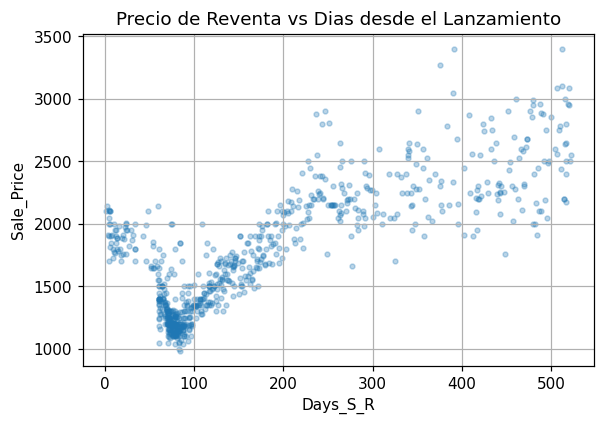

In [43]:
### Nuevo dataframe con valores de venta solamente del modelo a estudiar
Nike_jordan_off=Stock_original.loc[(Stock_original['Sneaker Name']=='Air-Jordan-1-Retro-High-Off-White-Chicago') 
                    & (Stock_original['Sale Price']<3500) & (Stock_original['Days_S_R']>0)].reset_index()

### Cambio de nombres de las columnas para usar stat models de scipy
Nike_jordan_off= Nike_jordan_off.rename(columns={
  'Sale Price': 'Sale_Price',
  'Shoe Size': 'Size_Shoe'})

#Scatter plot del precio de venta respecto a los dias desde el lanzamiento
Nike_jordan_off.plot.scatter('Days_S_R', 'Sale_Price', title="Precio de Reventa vs Dias desde el Lanzamiento",
                s = 10, alpha = 0.3, grid=True);

Por la gráfica de scatter anterior se puede ver cierta relación lineal entre las variables, por lo cual vale la pena hacer un análisis mas a fondo de esta posible relación.



Para esto se hará una regresión multilineal por medio de stats models de la forma:


> $y=m_{1}x_{1} + m_{2}x_{2}$

Donde $y$ será el precio de venta, $x_{1}$ corresponde a los días desde el lanzamiento y $x_{2}$ a la talla del producto, que a pesar de ser una variable discreta, e implica una cierta escala, por lo cual funciona para hacer la regresión.



In [38]:
model = sm.OLS.from_formula("Sale_Price ~ Days_S_R + Size_Shoe ", data=Nike_jordan_off)

result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             Sale_Price   R-squared:                       0.680
Model:                            OLS   Adj. R-squared:                  0.679
Method:                 Least Squares   F-statistic:                     792.8
Date:                Tue, 28 Mar 2023   Prob (F-statistic):          3.17e-185
Time:                        00:35:04   Log-Likelihood:                -5291.3
No. Observations:                 748   AIC:                         1.059e+04
Df Residuals:                     745   BIC:                         1.060e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1978.5338     68.028     29.084      0.000    1844.985    2112.083
Days_S_R       2.8146      0.074     38.028      0.000       2.669       2.960
Size_Shoe    -70.5210      6.356    -11.096      0.000     -82.998     -58.044
==============================================================================
Omnibus:                       77.815   Durbin-Watson:                   0.497
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               99.945
Skew:                           0.869   Prob(JB):                     1.98e-22
Kurtosis:                       3.432   Cond. No.                     1.50e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.5e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Se puede evidenciar un valor $R^2 = 0.68$ que indica un buen grado de correlación entre las variables.

En este caso la ecuación de la regresión toma la forma:

>$y= 2.81x_{1} - 70.52x_{2}$

Con las variables como se explicaron anteriormente.

En las siguientes celdas se definirá la ecuación y se calculará el valor esperado a día de hoy (27/03/2023) para luego compararlo con el valor real de la última venta del modelo en StockX.

In [44]:
Eq_model=lambda x,y: round(1978.5338 + 2.8146*x  -70.5210*y,2)

#Caculo de los dias desde el lanzamiento del modelo hasta el dia de hoy
days_today=(pd.to_datetime('2023-03-27') - pd.to_datetime('2018-06-23'))/np.timedelta64('1','D')
#Calculo del valor esperado a día de hoy para una talla 11
print('Precio de venta según la regresión al dia de hoy (USD):',Eq_model(days_today,11))	

Precio de venta según la regresión al dia de hoy (USD): 6094.58


El precio de venta a día de hoy, según StockX es:
<p align="center">
<img align="center" src = "https://drive.google.com/uc?export=view&id=1PMO0JTNogBO8wxFHG-n30yq-0hsC4Zfa" alt = "Nike_off_Chicago" width = "30%" >
</p>

Como se ve en la esquina inferior izquierda, la última venta el 24/03/2023 de este modelo fue por, 6562 USD.

Calculando el error porcentual del valor de venta real, con el predicho por el modelo, se tiene:

> <p align="center">$e.p=|\frac{v_{r}-v_{e}}{v_{e}}|*100$%$= |\frac{6094-6562}{6562}|*100$%$\approx 7$% </p>

El error porcentual es relativamente bajo, por lo cual se puede afirmar que el modelo de regresión multilineal es bastante bueno al momento de predecir los precios de reventa a lo largo del tiempo dependiendo de su talla.

### **Análisis de Outliers de los Precios de reventa para Encontrar Modelos de Sneakers más valiosos**

---------

En esta parte, se encontraran los Outliers del Data Frame original para hallar los modelos más valiosos al momento del lanzamiento del Data Contest de StockX.

Ya que la distribución de los datos en el precio de reventa no es normal, se usará el metodo IQR (Interquartile Range) para hallar los valores que pueden corresponder a Outliers.

En la siguiente gráfica de caja se muestran los rangos intercuartilicos correspondientes.


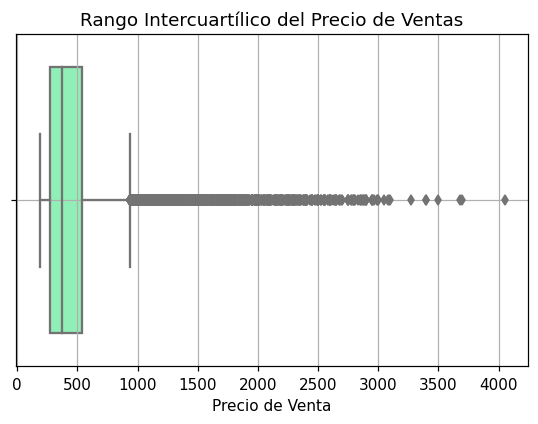

In [45]:
box_out = sns.boxplot(x="Sale Price",  
                 data=Stock_original, 
                 palette='rainbow')
box_out.grid()
box_out.set_title("Rango Intercuartílico del Precio de Ventas")
box_out.set_xlabel("Precio de Venta");

In [47]:
#Se hallan los Outliers por medio del metodo IQR y se crea un nuevo Data Frame con estos llamado outliers

IQR = Stock_original['Sale Price'].quantile(0.75) - Stock_original['Sale Price'].quantile(0.25)
Higher_outlier = Stock_original['Sale Price'].quantile(0.75) + (IQR * 1.5)
lower_outlier = Stock_original['Sale Price'].quantile(0.25) - (IQR * 1.5)
outl_wh=Stock_original.loc[Stock_original['Sale Price'] >= Higher_outlier, 'Sale Price']
outliers=Stock_original.filter(items=outl_wh.index, axis=0).reset_index()

En celda siguiente se realiza una gráfica interactiva de los outliers del precio de venta dependiente de los días desde su lanzamiento para las tallas más comunes (US8 a US12).

In [50]:
outlier_size=outliers.loc[(outliers['Shoe Size']>=8.0) & (outliers['Shoe Size']<=12)]
Fig_Out=px.scatter(outlier_size, 
       x="Days_S_R",     
       y="Retail Price",        
       color="Sale Price",     
       facet_col="Shoe Size", 
       marginal_x = 'histogram',
       hover_data=['Sneaker Name','Profit'],
       labels = {'Days_S_R': 'Días',
                       'Retail Price': 'Precio de Retail (USD)',
                       'Sale Price': 'Precio Venta(USD)',
                       'Shoe Size': 'Talla',
                       },
        color_continuous_scale=px.colors.sequential.Viridis        
       )
Fig_Out.update_layout(
    title={
        'text':'Analisis Interactivo de los Outliers del conjunto de Datos',
        'y':0.98,
        'x':0.45,
        'xanchor': 'center',
        'yanchor': 'top'})

Fig_Out.show()

*  En los histogramas superiores podemos observar el total de ventas en un rango determinado de días desde el lanzamiento del modelo según cada talla. Se puede destacar que para todas las tallas, los primeros 500 días se presentaron los mayores números de ventas. Esto es consistente, ya que la mayoría de vendedores prefieren vender los Sneaker antes de pasado un año de su adquisición.



*  Es claro que el modelo "Air-Jordan 1-Retro-Off-White-Chicago" es el que presenta el mayor valor de reventa entre los outliers y también la mayor ganancia con base en su precio de Retail. Aún así otros modelos como el "Nike-Air-Max-90-Off_White" y el "Air-Jordan 1-Retro-Off-White-University-Blue" también presentan una ganancia destacable del resto.

### **Análisis de Ventas por Estado**

--------------

En este último estudio se analiza el número de ventas de Sneakers por estado. El Geo Dataframe que se usó para la construcción del mapa de USA fue adquirido en la referencia [3]. Se omitieron Alaska y Hawaii por motivos de conveniencia al momento de graficar.

En la siguiente celda se preparan los datos para ser graficados correctamente.

In [52]:
#Preparación del Dataframe
States_fig.drop([2,11,37,52,53,54,55,56,57,58],axis=0,inplace=True)
States_fig=States_fig.sort_values(by=['NAME']).reset_index()
value_counts_re= Stock_original['Buyer Region'].value_counts().rename_axis('States').reset_index(name='counts')
value_counts_re.drop([33,47],axis=0,inplace=True)
counts=value_counts_re.sort_values(by=['States']).reset_index()
States_fig['sales_counts']=counts['counts']


[]

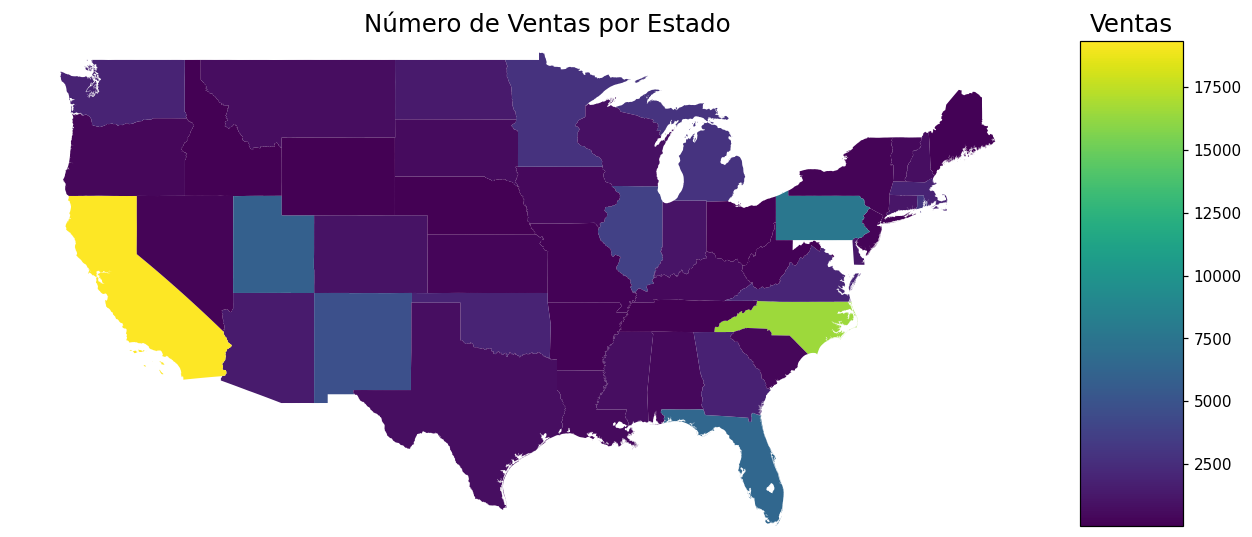

In [53]:
#Mapa coroplético del número de ventas de StockX usando el Dataframe correspondiente
fig, ax = plt.subplots(1, figsize=(15, 15))       
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="8%", pad=-1)  
cax.set_title('Ventas', fontsize=16)
ax.set_ylim(25,50)
ax.set_axis_off()
ax.set_title('Número de Ventas por Estado', fontsize=16)                    
Fig_states=States_fig.plot(column='sales_counts', # Argumento 'column': Variable a representar en el mapa coroplético.
           cmap='viridis',   # Método para definir el esquema de color. 
           figsize = (15,15),ax=ax,legend=True,cax=cax,
           legend_kwds={ "orientation": "vertical"});

Fig_states.plot()

Como se esperaba, el estado de California registra el mayor número de ventas del país. Posiblemente, la causa principal de esto es que California es por mucho el estado más poblado de US [4]. 

Es una sorpresa que el estado de New York no destaque entre los demás, ya que ha sido considerado por muchos años la capital de la cultura de los Sneaker en USA [4].

Finalmente, se destacan los estados de Pennsylvania y la Florida. Este último con un crecimiento considerable del consumo y la cultura de los Sneakers durante los últimos años [5]. Esto podría significar una oportunidad para que StockX crezca, aumentando sus enfoques publicitarios y de Marketing en estos estados.

# Referencías
--------


> [1] Russell, C. (2021, December 10). Adidas or Nike? which retail giant is winning the sneakers war? Forbes. Retrieved March 27, 2023, from https://www.forbes.com/sites/callyrussell/2019/08/22/adidas-or-nike-which-retail-giant-is-winning-the-sneakers-war/?sh=47bdd25512b7 

> [2] Miller, C. (2021, October 20). What is the average shoe size for men? the answer might surprise you. Footwear News. Retrieved March 27, 2023, from https://footwearnews.com/feature/average-shoe-size-men-1202752232/ 


> [3] US Department of Commerce, N. O. A. A. (2023, January 17). U.S. states and Territories. National Weather Service. Retrieved March 27, 2023, from https://www.weather.gov/gis/USStates 

> [4] Leach, W. B. A., &amp; Writer/Editor/Consultant, A. L. F. (2015, July 6). Here's how every U.S. state ranks in sneaker reselling. Highsnobiety. Retrieved March 27, 2023, from https://www.highsnobiety.com/p/best-sneaker-resell-states/ 

> [5] Leach, W. B. A., &amp; Writer/Editor/Consultant, A. L. F. (2015, July 6). Here's how every U.S. state ranks in sneaker reselling. Highsnobiety. Retrieved March 27, 2023, from https://www.highsnobiety.com/p/best-sneaker-resell-states/ 